## Imports

In [1]:
import pandas as pd 
import numpy as np
from collections import Counter

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

OVERSAMPLE = False
PERFORM_PCA = False

## Data Preprocessing

In [2]:
all_cat_vars = ['Profession', 'Status', 'edu', 'Irregular', 'residence', 'prev_diagnosed', 'communication', 'Month', 'side_effects']
categorical_vars = ['Profession', 'Status', 'edu', 'communication', 'Month', 'side_effects']
continuous_vars = ['age', 'Money']

def load_data(csv_file, impute=False):
    df = pd.read_csv(csv_file)
    df = df.drop(columns=['ID'])

    # impute missing values
    if impute:
        for col in all_cat_vars:
            df[col] = df[col].fillna(df[col].value_counts().index[0])
        imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        df[continuous_vars] = imputer.fit_transform(df[continuous_vars].values)

    # encode categorical variables
    df = df.replace({'no': 0, 'yes': 1})
    categorical_vars = ['Profession', 'edu', 'Status', 'communication', 'Month', 'side_effects']
    df = pd.get_dummies(df, columns=categorical_vars)
    return df

train = load_data('../input/pasc-data-quest-20-20/doctor_train.csv', impute=True)

LGBM & XGBoost, the models I'll be using, handle missing values implicitly. Although in order to perform PCA (Principal Component Analysis) scaling and imputing is required.

In [3]:
train.head()

,age,Irregular,Money,residence,prev_diagnosed,day,Time,Doctor_visits,last_visit,cured_in,...,Month_jun,Month_mar,Month_may,Month_nov,Month_oct,Month_sep,side_effects_failure,side_effects_other,side_effects_success,side_effects_unknown
0,30.0,0,1466.0,0,0,12,111,4,-1,0,...,0,0,0,0,0,0,0,0,0,1
1,35.0,0,278.0,0,0,21,84,1,-1,0,...,0,0,0,0,0,1,0,0,0,1
2,41.0,0,6060.0,1,0,15,71,2,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,32.0,0,642.0,0,1,8,524,1,-1,0,...,0,0,0,0,0,0,0,0,0,1
4,39.0,0,2598.0,0,0,17,123,1,-1,0,...,0,0,0,1,0,0,0,0,0,1


In [4]:
# classes distribution
ratio = list(train['Y'].value_counts())
ratio

[24887, 3309]

In [5]:
def split(df):
    y = df['Y']
    X = df[[x for x in df.columns if x != 'Y']]
    return X, y

X, y = split(train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('train:', X_train.shape, y_train.shape)
print('test:', X_test.shape, y_test.shape)

train: (19737, 48) (19737,)
test: (8459, 48) (8459,)


In [6]:
# oversampling
if OVERSAMPLE:
    from imblearn.over_sampling import RandomOverSampler
    oversample = RandomOverSampler(sampling_strategy='minority', random_state=0)
    X_over, y_over = oversample.fit_resample(X, y)

In [7]:
if OVERSAMPLE:
    print(Counter(y_train))
    print(Counter(y_over))

In order to handle imbalanced classes oversampling is performed. It duplicates randomly selected rows from the dataset as per the strategy used.

The models we'll be using have a different parameter to handle imbalanced distribution.

In [8]:
# principal component analysis
if PERFORM_PCA:
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    pca = PCA(.95)
    pca.fit(X_train)
    print(pca.n_components_)

In [9]:
if PERFORM_PCA:
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

## Feature Selection


[03:23:01] WARNING: /workspace/src/learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




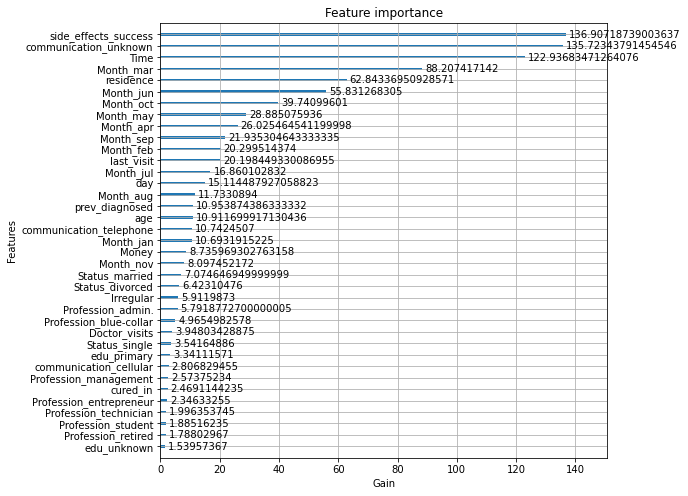

In [10]:
# feature selection

dtrain = xgboost.DMatrix(X, y)

params = {
    'scale_pos_weight': max(ratio)/min(ratio),
    'n_estimators': 400
}
num_rounds = 5

bst = xgboost.train(params, dtrain, num_rounds)
ax = xgboost.plot_importance(bst, 
                             importance_type='gain', 
                             max_num_features=len(X_train.columns), 
                             xlabel='Gain')
fig = ax.figure
fig.set_size_inches(8, 8)

Dropping columns / Dimensionality reduction for this dataset reduced the performance, but be sure to experiment with it.

## Models

In [11]:
# Evaluation
def results(model):
    pred = model.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, pred))
    print('f1 score:', f1_score(y_test, pred))
    print('ROC-AUC:', roc_auc_score(y_test, pred))
    print('\nConfusion matrix:')
    return confusion_matrix(y_test, pred)

GridSearch used for Hyperparamter Tuning. Tuning one parameter at a time is convenient, but multiple parameters can be passed too.

### LGBM Model

In [12]:
# LGBM

# Tuned LGBM model
# lgbm_model = LGBMClassifier(scale_pos_weight=10,
                            # n_estimators=140,
                            # learning_rate=0.17,
                            # max_depth=8,
                            # num_leaves=30,
                            # reg_alpha=0.2,
                            # reg_lambda=0.2,
                            # subsample=0.1,
                            # gamma=0
                            # )

# This configuration gives the best results on this dataset 
lgbm_model = LGBMClassifier(scale_pos_weight=10,
                            n_estimators=140
                            )

GRID_SEARCH = False
if GRID_SEARCH:
    param_dist = {
        'scale_pos_weight': [7, 7.1, 7.2, 7.3, max(ratio)/min(ratio), 8],
        }
    grid_search = GridSearchCV(lgbm_model, 
                            n_jobs=-1, 
                            param_grid=param_dist, 
                            cv = 3, 
                            scoring='f1', 
                            verbose=5)
    grid_search.fit(X_train, y_train)

    print(grid_search.best_params_, grid_search.best_score_)
    results = pd.DataFrame(grid_search.cv_results_)
    results[['mean_test_score', 'std_test_score', 'params']]

In [13]:
lgbm_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=140, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               scale_pos_weight=10, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [14]:
results(lgbm_model)

Accuracy: 0.8627497340111124
f1 score: 0.6076377154444069
ROC-AUC: 0.8613389505645991

Confusion matrix:


array([[6399, 1014],
       [ 147,  899]])

### XGBoost Model

In [15]:
# XGBoost

# Tuned XGBoost model
# xgb_model = XGBClassifier(scale_pos_weight=max(ratio)/min(ratio),
                        #   n_estimators=439,
                        #   gamma=0.28,
                        #   reg_alpha=0.8,
                        #   reg_lambda=1.5,
                        #   learning_rate=0.117,
                        #   max_depth=5,
                        #   colsample_bytree=0.565,
                        #   subsample=0.8
                        #   )

# This configuration gives the best results on this dataset 
xgb_model = XGBClassifier(scale_pos_weight=max(ratio)/min(ratio),
                          n_estimators=439
                          )
GRID_SEARCH = False
if GRID_SEARCH:
    params = {
        'scale_pos_weight': [max(ratio)/min(ratio)+0.1, max(ratio)/min(ratio)+0.2, max(ratio)/min(ratio)+0.3]
        }

    grid_search = GridSearchCV(model, 
                            param_grid = params, 
                            scoring='f1',
                            n_jobs=-1,
                            cv=3,
                            verbose=5)
    grid_search.fit(X, y)
    print(grid_search.best_params_, grid_search.best_score_)
    results = pd.DataFrame(grid_search.cv_results_)
    results[['mean_test_score', 'std_test_score', 'params']]

In [16]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=439, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=7.52100332426715, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [17]:
results(xgb_model)

Accuracy: 0.8946684005201561
f1 score: 0.5853885528152628
ROC-AUC: 0.7686983540619948

Confusion matrix:


array([[6939,  474],
       [ 417,  629]])

The most important hyperparamter in both the models is 'scale_pos_weight'. This hyperparameter is responsible for handling the imbalanced distribution of classes.

An optimum value is the count of the majority class examples divided by the count of the minority class examples. Experimenting with this value can provide major differences in performance.

### Stacked LGBM + XGBoost

Stacking is a popular technique which is the combining of two or more machine learning models. Here I've taken the mean of the results predicted by both the models.

In [18]:
# combined xgb + lgbm
xgb_pred = xgb_model.predict(X_test)
lgbm_pred = lgbm_model.predict(X_test)
pred = []
for xgb, lgbm in zip(xgb_pred, lgbm_pred):
    pred.append(round(np.mean([xgb, lgbm])))

print('Accuracy:', accuracy_score(y_test, pred))
print('f1 score:', f1_score(y_test, pred))
print('ROC-AUC:', roc_auc_score(y_test, pred))
print('\nConfusion matrix:')
confusion_matrix(y_test, pred)

Accuracy: 0.8954959215037238
f1 score: 0.5853658536585367
ROC-AUC: 0.7671176856119901

Confusion matrix:


array([[6951,  462],
       [ 422,  624]])

### Comparison Table

In [19]:
# comparing all models
def get_results(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return acc, f1, roc_auc

xgb_acc, xgb_f1, xgb_roc_auc = get_results(y_test, xgb_model.predict(X_test))
lgbm_acc, lgbm_f1, lgbm_roc_auc = get_results(y_test, lgbm_model.predict(X_test))

xgb_pred = xgb_model.predict(X_test)
lgbm_pred = lgbm_model.predict(X_test)
stacked_pred = []
for xgb, lgbm in zip(xgb_pred, lgbm_pred):
    stacked_pred.append(round(np.mean([xgb, lgbm])))
stacked_acc, stacked_f1, stacked_roc_auc = get_results(y_test, stacked_pred)

print('\t\t\tStacked\t\t\tXGBoost\t\t\tLGBM\n')
print('Accuracy\t', stacked_acc, '\t', xgb_acc, '\t', lgbm_acc)
print('F1 Score\t', stacked_f1, '\t', xgb_f1, '\t', lgbm_f1)
print('ROC AUC Score\t', stacked_roc_auc, '\t', xgb_roc_auc, '\t', lgbm_roc_auc)

			Stacked			XGBoost			LGBM

Accuracy	 0.8954959215037238 	 0.8946684005201561 	 0.8627497340111124
F1 Score	 0.5853658536585367 	 0.5853885528152628 	 0.6076377154444069
ROC AUC Score	 0.7671176856119901 	 0.7686983540619948 	 0.8613389505645991


The LGBM Model has the highest ROC-AUC score and thus outperforms the others.

## Submission

In [ ]:
# submission

def submit(model, output_file='submission'):
    test = load_data('../input/pasc-data-quest-20-20/doctor_test.csv')
    pred = model.predict(test.values)
    pred.tolist()

    submission = pd.DataFrame()
    submission['ID'] = range(0, len(test))

    submission['Y'] = pred
    submission['Y'] = submission['Y'].replace({0:'no', 1:'yes'})
    submission.to_csv(output_file + '.csv', index=False)

    print(submission.shape)
    print(output_file + '.csv saved!')
    return submission.head()

submit(lgbm_model, 'submission_lgbm')